# Preparing Features to predict Stock Returns

## Imports

In [1]:
import yaml
import numpy as np
import pandas as pd
from talib import BBANDS, RSI,ATR, MACD
from scipy.stats import pearsonr, spearmanr

import seaborn as sns
import matplotlib.pyplot as plt

## Settings & variables

In [2]:
# Open the YAML file and load its contents into a dictionary
with open('../../references/config_notebook.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Access the variables in the dictionary
my_vars = config

In [3]:
# Data location
source_folder_path = my_vars['DATA']['interim']

##  Load data from Parquet file

In [4]:

# Read the Parquet file into a DataFrame
BTCUSDT_1_minute = pd.read_parquet(f'{source_folder_path}/BTCUSDT_1_minute.parquet', engine='fastparquet')

# Set the timestamp column as the index
BTCUSDT_1_minute.set_index('timestamp', inplace=True)
BTCUSDT_1_minute.sort_index(inplace=True)
BTCUSDT_1_minute.head()

,open,close,high,low,volume,price,quoteQty,transactions_count,max_quoteQty_sum,percentage_of_biggest_transaction,zipname
timestamp,,,,,,,,,,,
2021-03-01 00:00:00,45134.11,45260.74,45266.77,45130.34,72.517978,45198.32,3.277691e+06,2207,113983.707600,3.48,20210301
2021-03-01 00:01:00,45252.67,45356.00,45362.07,45250.64,65.371778,45307.55,2.961835e+06,2028,103760.964721,3.50,20210301
2021-03-01 00:02:00,45356.00,45128.57,45371.41,45104.36,128.114624,45237.23,5.795551e+06,2706,189539.886177,3.27,20210301
2021-03-01 00:03:00,45128.57,45037.36,45194.65,45020.87,59.964922,45137.70,2.706678e+06,1502,51584.435987,1.91,20210301
2021-03-01 00:04:00,45036.62,45032.48,45107.01,44977.82,57.852895,45039.67,2.605675e+06,1250,226942.213150,8.71,20210301


In [5]:
df = BTCUSDT_1_minute[['open', 'close', 'high', 'low', 'volume', 'quoteQty', 'transactions_count']].copy()
df.head()

,open,close,high,low,volume,quoteQty,transactions_count
timestamp,,,,,,,
2021-03-01 00:00:00,45134.11,45260.74,45266.77,45130.34,72.517978,3.277691e+06,2207
2021-03-01 00:01:00,45252.67,45356.00,45362.07,45250.64,65.371778,2.961835e+06,2028
2021-03-01 00:02:00,45356.00,45128.57,45371.41,45104.36,128.114624,5.795551e+06,2706
2021-03-01 00:03:00,45128.57,45037.36,45194.65,45020.87,59.964922,2.706678e+06,1502
2021-03-01 00:04:00,45036.62,45032.48,45107.01,44977.82,57.852895,2.605675e+06,1250


<Axes: xlabel='timestamp'>

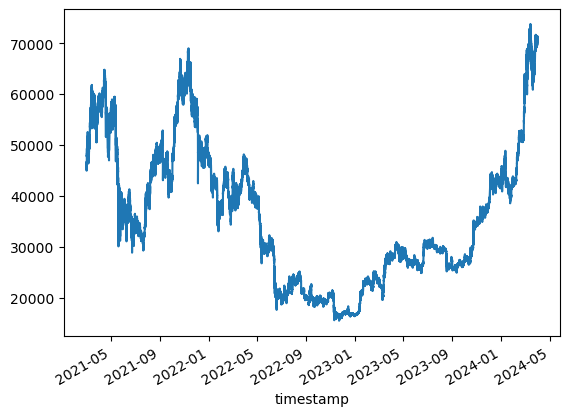

In [6]:
df['close'].plot()

# Add some Features

In [7]:
# Calculate the ending price of TWLO for each day
last_price_of_the_day = df.groupby(df.index.date).tail(1)['close'].rename('day_close_price') 
last_price_of_the_day.index = last_price_of_the_day.index.date 

In [8]:
# Add a column to our price dataframe to represent the date
df['day'] = df.index.date 

In [9]:
# Merge the ending prices into our granular dataframe
df = df.merge(last_price_of_the_day, left_on='day', right_index=True)

In [10]:
# The percent change from now until the end of the day
df['pct_change_eod'] = (df['day_close_price'] - df['close']) / df['close']

In [11]:
#Create our response column: a binary response
df['stock_price_rose'] = df['pct_change_eod'] > 0

In [12]:
df.head()

,open,close,high,low,volume,quoteQty,transactions_count,day,day_close_price,pct_change_eod,stock_price_rose
timestamp,,,,,,,,,,,
2021-03-01 00:00:00,45134.11,45260.74,45266.77,45130.34,72.517978,3.277691e+06,2207,2021-03-01,49587.03,0.095586,True
2021-03-01 00:01:00,45252.67,45356.00,45362.07,45250.64,65.371778,2.961835e+06,2028,2021-03-01,49587.03,0.093285,True
2021-03-01 00:02:00,45356.00,45128.57,45371.41,45104.36,128.114624,5.795551e+06,2706,2021-03-01,49587.03,0.098795,True
2021-03-01 00:03:00,45128.57,45037.36,45194.65,45020.87,59.964922,2.706678e+06,1502,2021-03-01,49587.03,0.101020,True
2021-03-01 00:04:00,45036.62,45032.48,45107.01,44977.82,57.852895,2.605675e+06,1250,2021-03-01,49587.03,0.101139,True


## Lag / Rolling Window features

In [13]:
df['feature__lag_30_min_ago_price'] = df['close'].shift(30, freq='min')
df['feature__lag_7_day_ago_price'] = df['close'].shift(7, freq='D')

Text(0, 0.5, 'Price')

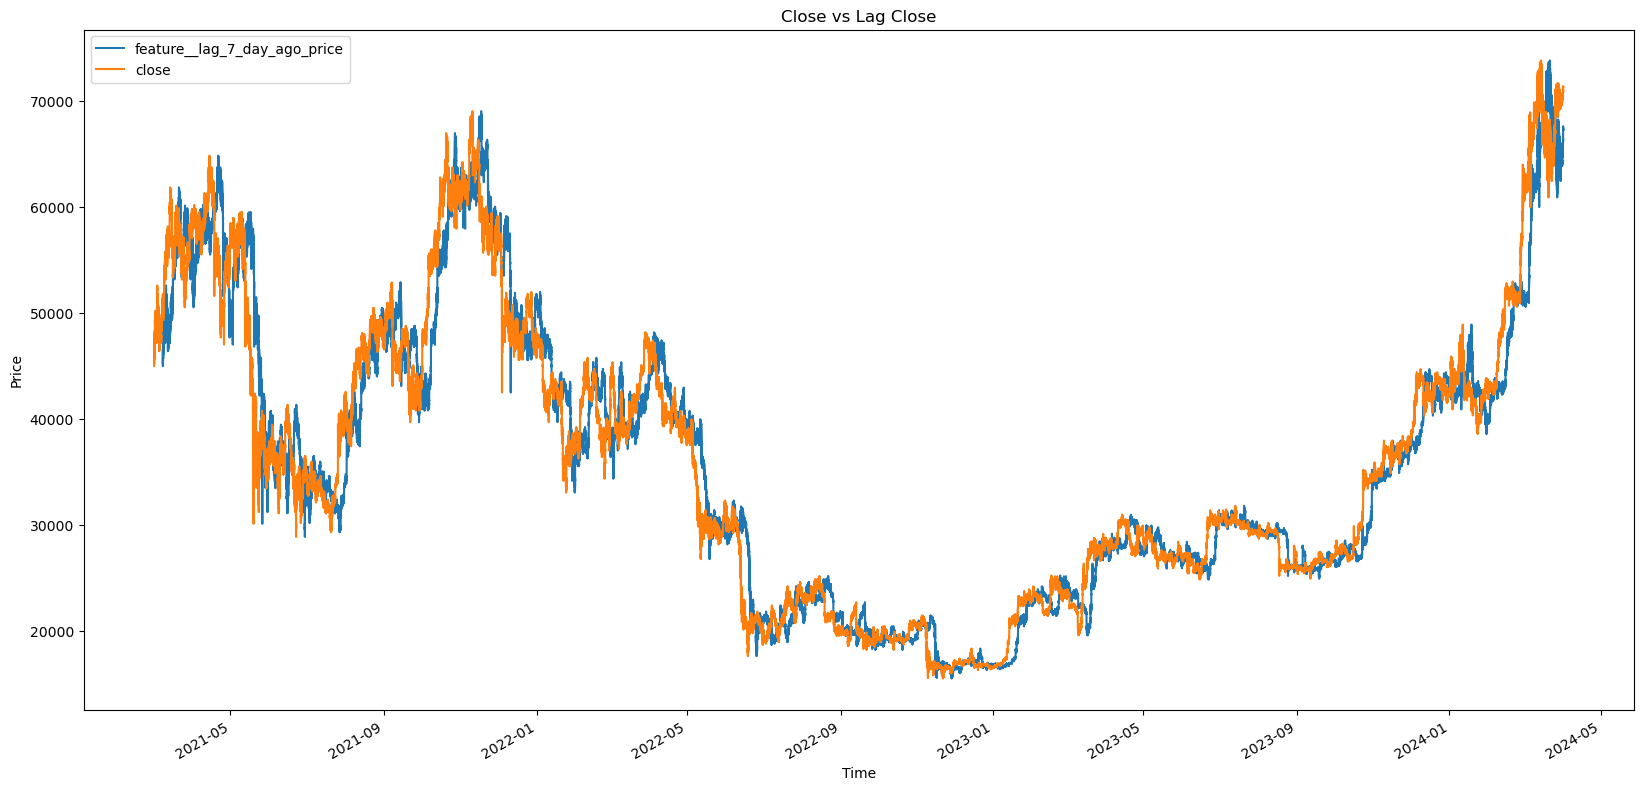

In [14]:
df['feature__lag_7_day_ago_price'].plot(figsize=(20,10), title='Close vs Lag Close')
df['close'].plot()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')

In [15]:
df['feature__rolling_close_mean_60'] = df['close'].rolling('60min').mean() # A
df['feature__rolling_close_std_60'] = df['close'].rolling('60min').std() # B
df['feature__rolling_volume_mean_60'] = df['volume'].rolling('60min').mean() # C
df['feature__rolling_volume_std_60'] = df['volume'].rolling('60min').std() # D

Text(0, 0.5, 'Price')

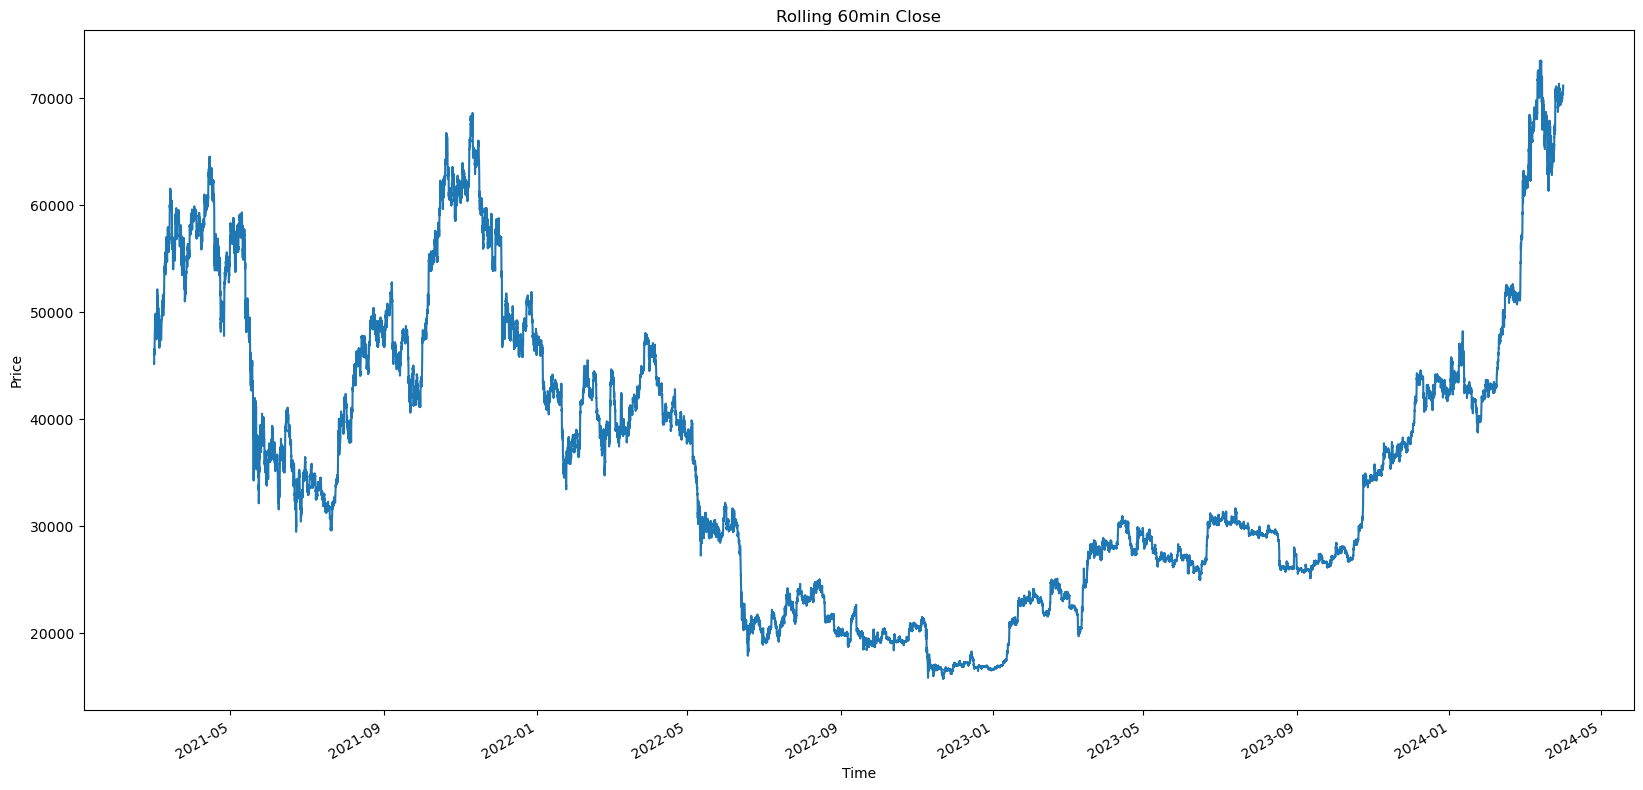

In [16]:
df['feature__rolling_close_mean_60'].plot(figsize=(20, 10), title='Rolling 60min Close')

plt.xlabel('Time')
plt.ylabel('Price')

In [17]:
df['feature__expanding_close_mean'] = df['close'].expanding(200).mean()
df['feature__expanding_volume_mean'] = df['volume'].expanding(200).mean()

df.dropna(inplace=True)

Text(0, 0.5, 'Price')

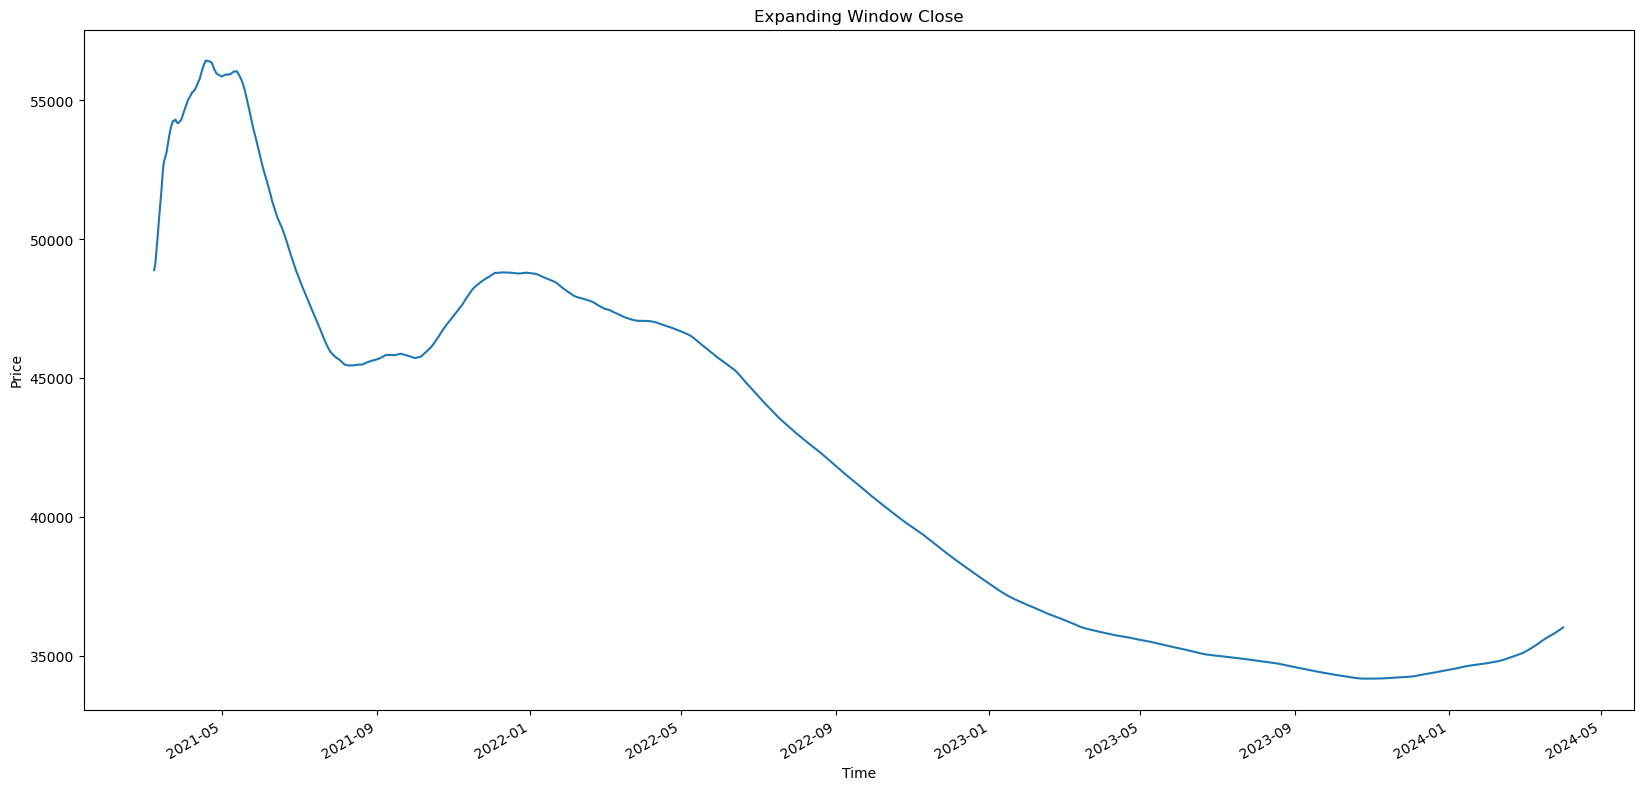

In [18]:
df['feature__expanding_close_mean'].plot(figsize=(20, 10), title='Expanding Window Close')

plt.xlabel('Time')
plt.ylabel('Price')

Text(0, 0.5, 'Shares')

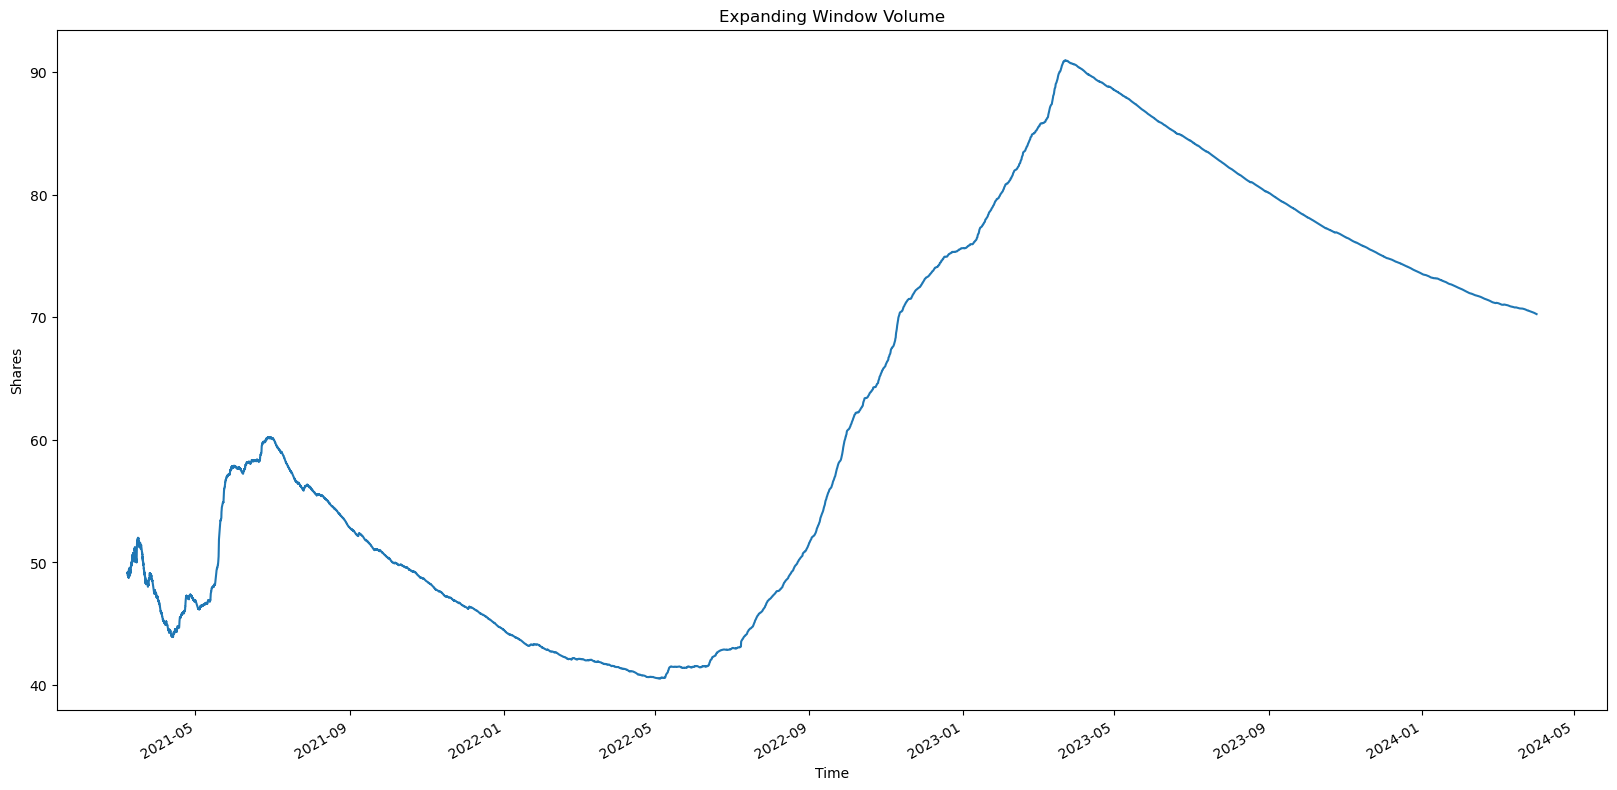

In [19]:
df['feature__expanding_volume_mean'].plot(figsize=(20, 10), title='Expanding Window Volume')  # A

plt.xlabel('Time')
plt.ylabel('Shares')

# A plot our expanding window features

## Add some Basic Factors

### Compute the Relative Strength Index

In [20]:
# Calculate RSI using TA-Lib
df['rsi'] = RSI(df['close'],14)

In [21]:
# Drop NA values from the 'rsi' column
rsi_values = df['rsi'].dropna()

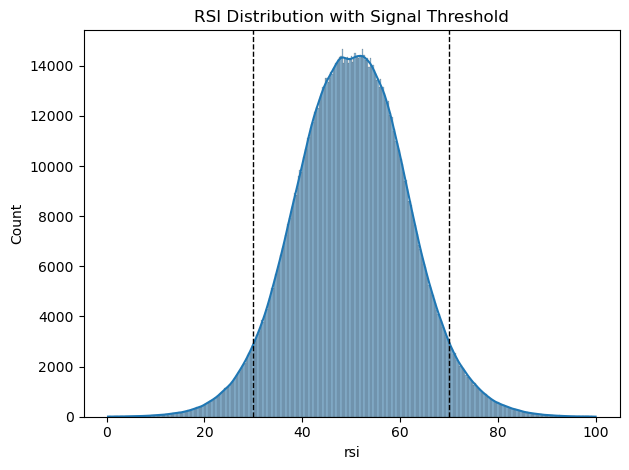

In [22]:
# Create a histogram plot of the RSI values
ax = sns.histplot(rsi_values, kde=True)

# Add vertical lines at RSI threshold levels
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')

# Set title for the plot
ax.set_title('RSI Distribution with Signal Threshold')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

### Compute Bollinger Bands

In [23]:
# Function to compute Bollinger Bands
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [24]:
# Calculate Bollinger Bands
bollinger_bands = compute_bb(df['close'])
df = df.join(bollinger_bands)


In [25]:
# Calculate normalized distance from the bands
df['bb_high'] = (df['bb_high'] - df['close']) / df['bb_high']
df['bb_low'] = (df['close'] - df['bb_low']) / df['close']


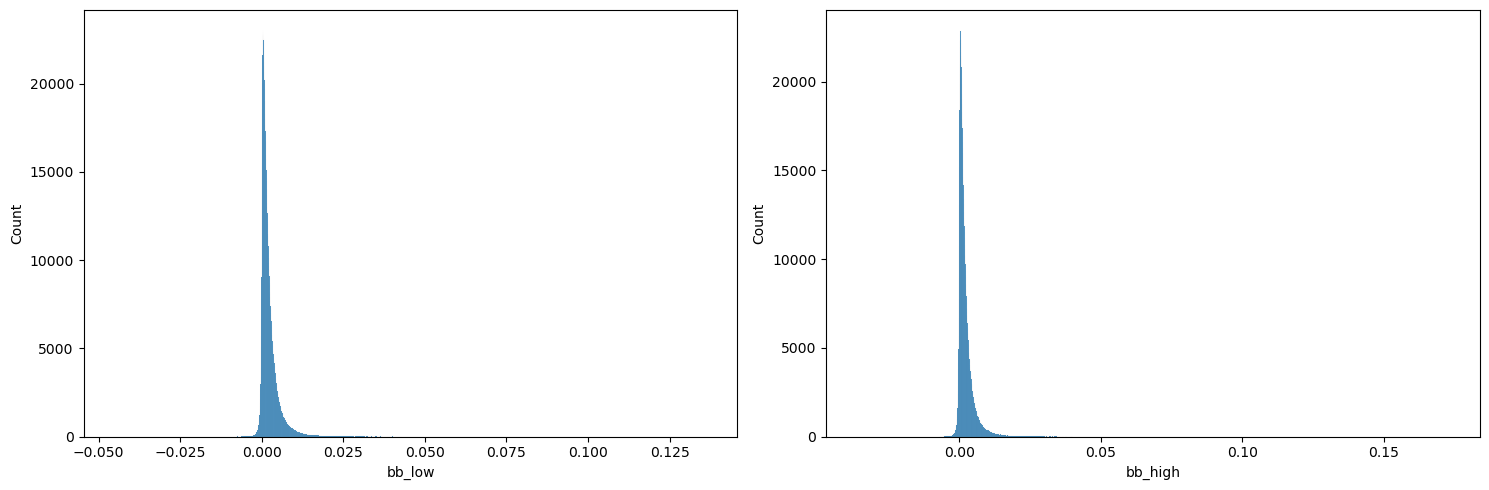

In [26]:
# Plot the distributions of normalized distances from the bands
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['bb_low'].dropna(), ax=axes[0])
sns.histplot(df['bb_high'].dropna(), ax=axes[1])
plt.tight_layout()
plt.show()

### Compute Average True Range

In [27]:
# Function to compute the Average True Range
df['atr'] = ATR(df.high, df.low, df.close, timeperiod=14)

### Compute Moving Average Convergence/Divergence

In [28]:
macd, macdsignal, macdhist = MACD(df.close, fastperiod=12, slowperiod=26, signalperiod=9)

In [29]:
# Calculate the Moving Average Convergence/Divergence
df['macd'] = macd

# Create the interim database

In [32]:
df.dropna(subset=['rsi','bb_high','bb_low','atr','macd'], inplace=True)


In [36]:
df['day'] = pd.to_datetime(df['day'])

In [37]:
df.to_parquet('/home/giujorge/Documents/Projets/phoenix/data/interim/database_feature.parquet')

In [38]:
df.head()

,open,close,high,low,volume,quoteQty,transactions_count,day,day_close_price,pct_change_eod,...,feature__rolling_close_std_60,feature__rolling_volume_mean_60,feature__rolling_volume_std_60,feature__expanding_close_mean,feature__expanding_volume_mean,rsi,bb_high,bb_low,atr,macd
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-03-08 00:33:00,51607.22,51609.12,51617.00,51584.91,18.988774,9.798337e+05,792,2021-03-08,52375.17,0.014843,...,211.581838,59.999661,37.580587,48897.757139,49.162984,66.414082,0.001388,0.004597,98.972939,115.854261
2021-03-08 00:34:00,51609.12,51570.75,51645.00,51538.13,48.776246,2.516397e+06,1215,2021-03-08,52375.17,0.015598,...,211.538742,60.225673,37.469621,48898.023772,49.162946,62.839838,0.001976,0.003299,99.537015,108.772610
2021-03-08 00:35:00,51570.75,51433.83,51577.06,51400.00,66.814359,3.438968e+06,1813,2021-03-08,52375.17,0.018302,...,206.678229,60.629102,37.406983,48898.276695,49.164706,52.070778,0.004675,0.000766,105.074371,91.062341
2021-03-08 00:36:00,51433.84,51464.80,51513.53,51416.00,39.825214,2.050003e+06,838,2021-03-08,52375.17,0.017689,...,203.289713,60.059888,37.460222,48898.532656,49.163775,53.991395,0.003946,0.001111,104.535487,78.619568
2021-03-08 00:37:00,51464.81,51534.76,51587.85,51442.46,54.571681,2.811718e+06,1059,2021-03-08,52375.17,0.016308,...,200.547777,60.194191,37.425261,48898.795542,49.164314,58.078112,0.002600,0.002391,107.453667,73.555861
